# Manually updating the Q value

In [ ]:
import gym
import numpy as np

In [ ]:
env = gym.make("MountainCar-v0")  # a very simple application
done = False

# Resets the state of the environment and returns an initial observation.
env.reset()  # 2 observables - position and velocity

# number of allowed actions  - 3: left push, no movement, right push
# print(env.action_space.n)

# there are only two observables - position and velocity
# print(env.observation_space.high)  # the high values of the observations
# print(env.observation_space.low)  # the low values

# the range of values for observation 1 is 0.6 to -1.2
# and similarly for observation 2 its 0.07 to -0.07
# we can segregate the values in 20 chunks (can be any value)

DISCRETE_OBSERVATION_SPACE_SIZE = [
    20] * len(env.observation_space.high)  # will give out 20*20 list

# see how big is the range for each of the 20 different buckets
discrete_os_win_size = (env.observation_space.high -
                        env.observation_space.low) / DISCRETE_OBSERVATION_SPACE_SIZE

LEARNING_RATE = 0.1
DISCOUNT = 0.95  # how important we find the new future actions are ; future reward over current reward
EPISODES = 20000
render = False

# even though the solution might have been found, we still wish to look for other solutions
epsilon = 0.5  # 0-1 ; higher it is, more likely for it to perform something random action
START_EPSILON_DECAYING = 1
# python2 style division - gives only int values
END_EPSILON_DECAYING = EPISODES // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

# Q learning
# so we will have now a table such that each row will have 400 (20*20) rows for the possible state the agent can be in
# and 3 columns for the 3 possible actions
# the agent will see which state it is in and take the action corresponding to the largest Q value

# Create a randomised q_table and agent will update it after exploring the environment
q_table = np.random.uniform(
    low=-2, high=0, size=(DISCRETE_OBSERVATION_SPACE_SIZE + [env.action_space.n]))

# how to set low and high limits of rewards ? - if you see the rewards printed in below cell, they are mostly -1 and
# might be something +ve only when you reach goal. Needs tweaking and playing around
# print(q_table.shape)


def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) / discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # return as tuple


# # get Q value of this discrete state
# print(q_table[discrete_state])

# # print action corresponding to the max Q value
# print(np.argmax(q_table[discrete_state]))

# # print the max q-value for that state
# print(np.max(q_table[discrete_state]))


In [ ]:
for ep in range(EPISODES):
    done = False
    discrete_state = get_discrete_state(env.reset())  # initial discrete state

    if ep % 500 == 0:
        render = True
    else:
        render = False
        env.close()


    while not done:  # goal reached means reward = 0

        if np.random.random() > epsilon:
            # in this environment, 0 means push the car left, 1 means to do nothing, 2 means to push it right
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)

        # Run one timestep of the environment's dynamics;  returns a tuple (observation, reward, done, info).
        new_state, reward, done, _ = env.step(action)

        new_discrete_state = get_discrete_state(new_state)

        if render:
            env.render()

        if not done:
            # max q value for the next state calculated above
            max_future_q = np.max(q_table[new_discrete_state])

            # q value for the current action and state
            current_q = q_table[discrete_state + (action, )]

            new_q = (1 - LEARNING_RATE) * current_q + \
                LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # based on the new q, we update the current Q value
            q_table[discrete_state + (action, )] = new_q

        # goal reached; reward = 0 and no more negative
        elif new_state[0] >= env.goal_position:
            print(("Goal reached at {} episode".format(ep)))
            # its like a snowbal effect, once the goal is reached - it will most likely reach again soon enough
            q_table[discrete_state + (action, )] = 0

        discrete_state = new_discrete_state

    if END_EPSILON_DECAYING >= ep >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

env.close()

# Using neural network


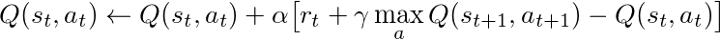

The portion inside the brackets becomes the loss function for our neural network where Q(st,at) is the output of our network and rt + γ max Q(st+1,at+1) is the target Q value as well as the label for our neural net turning the problem into a supervised learning problem solvable using gradient descent where α is our learning rate.



Using a single layer and 200 hidden unit network to learn the policy.

In [ ]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import gym
import numpy as np

In [ ]:
class policy(nn.Module):
    def __init__(self):
        super(policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 200 # num of hidden units 
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False) # input layer to hidden layer 
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)  # hidden layer to output layer
        
    def forward(self, x):
        model = nn.Sequential(self.l1, self.l2)  # creating a model with the given layers
        return model(x)


In [ ]:
# Parameters
steps = 2000
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 1000
max_position = -0.4
learning_rate = 0.03
successes = 0
position = []

# Initialize Policy
env = gym.make('MountainCar-v0')
state = env.reset()
pol = policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(pol.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [ ]:
for episode in range(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        if episode % 200 == 0 and episode > 0:
            env.render()
        
        # Get first action value function
        Q = pol(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        new_state, reward, done, _ = env.step(action)
        
        new_Q = pol(Variable(torch.from_numpy(new_state).type(torch.FloatTensor)))
        max_new_Q, _ = torch.max(new_Q, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target.data)
        Q_target[action] = reward + torch.mul(max_new_Q.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        pol.zero_grad()
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
        
        # Keep track of max position
        if new_state[0] > max_position:
            max_position = new_state[0]
        
        if done:
            if new_state[0] >= 0.5:
                print("Success at episode ", ep)
                epsilon *= .99                 # Adjust epsilon
                scheduler.step()                # Adjust learning rate
                successes += 1                # Record successful episode
                
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            weights = np.sum(np.abs(pol.l2.weight.data.numpy()))+np.sum(np.abs(pol.l1.weight.data.numpy()))
            position.append(new_state[0])

            break
        else:
            state = new_state
            
print('successful episodes: {}'.format(successes))